<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
   - 2.1 Feature Removal from Part 1
   - 2.2 Variance Threshold
   - 2.3 Correlation Analysis
   - 2.4 Statistical Hypothesis Testing
   - 2.5 Model-Based Feature Importance
   - 2.6 Optimal Feature Set Selection
3. [Regression Benchmarking](#3-benchmarking)
   - 3.1 Model Assessment Strategy and Metrics
   - 3.2 Model Configuration, Hyperparameter Search and Results
   - 3.3 Final Model
4. [Open-Ended Section](#4-open-ended-section)
   - 4.1 Webapp for Price Prediction and Dashboard Visualization
   - 4.2 Model Interpretability (LIME)

---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

We load the preprocessed datasets from Part 1 and prepare them for model training. Log-transformed target arrays are created to reduce the impact of price outliers. A combined training set (train + validation) is prepared for final model training before Kaggle submission.

### 1.1 Import Libraries

In [ ]:
# =========================
# Standard library
# =========================
import random
from itertools import product

# =========================
# Data manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# =========================
# Scikit-learn - Utilities
# =========================
from sklearn.base import clone

# =========================
# Scikit-learn - Feature Selection
# =========================
from sklearn.feature_selection import VarianceThreshold

# =========================
# Scikit-learn - Models
# =========================
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
)
from sklearn.neighbors import KNeighborsRegressor

# =========================
# Scikit-learn - Metrics
# =========================
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_pinball_loss,
)

# =========================
# Explainability
# =========================
import lime
import lime.lime_tabular

# =========================
# Utilities / Persistence
# =========================
import joblib
import utils

# =========================
# Plot style
# =========================
palette = ['#5C4212', '#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120', '#f39c06', '#f2e209']

# =========================
# Reproducibility
# =========================
random.seed(37)
np.random.seed(37)


### 1.2 Load Data

In [2]:
# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,768 rows, 37 features
Val:   15,193 rows
Test:  32,567 rows


In [3]:
# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,768
Val samples:   15,193
Full samples:  75,961


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

Feature selection reduces dimensionality, mitigates overfitting, and improves interpretability. We apply a multi-method approach:

1. **Business-Based Removal**: Exclude features unavailable at prediction time (paintQuality%)
2. **Variance Threshold**: Remove near-constant features (variance ≤ 0.01)
3. **Correlation Analysis**: Identify features with weak target relationships
4. **Statistical Testing**: F-regression tests for predictive significance
5. **Model-Based Selection**: Tree importance and Lasso coefficients

The final feature set balances predictive power with model parsimony.

### 2.1 Feature Removal from Part 1

In Part 1 (Data Preprocessing), we already removed the following features:
- **`year`**: Replaced by derived features (`age`, `age_squared`, `is_new_car`, `is_old_car`)
- **`model`**: Encoded via target encoding (`model_mean_price`, `model_popularity`)
- **`paintQuality%`**: Not available at prediction time (filled by mechanic during evaluation)

We now proceed with additional feature selection techniques on the remaining 37 features.

### 2.2 Variance Threshold

We apply a variance threshold filter to remove features with near-zero variance, as they provide little discriminative power for prediction.

In [4]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 4
Features with variance closer to zero:
hasDamage: 0.0000
transmission_other: 0.0000
fuelType_electric: 0.0001
fuelType_other: 0.0022


### 2.3 Correlation Analysis with Target

We compute Spearman correlation coefficients between each feature and the target variable (log-transformed price) to identify the less relevant predictors.

In [5]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([
    X_train_scaled, 
    pd.Series(y_train_log, index=X_train_scaled.index, name='price')
], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,model_mean_price,0.765409,0.765409
1,mpg_per_liter,-0.598963,0.598963
2,age,-0.595517,0.595517
3,age_squared,-0.595517,0.595517
4,brand_mean_price,0.579865,0.579865
5,transmission_manual,-0.579796,0.579796
6,age_mileage_interaction,-0.570180,0.570180
7,engineSize,0.562210,0.562210
8,brand_price_std,0.547267,0.547267
9,premium_brand_engine_size_interaction,0.546488,0.546488


\ Features with |corr| < 0.1 (11):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073977,0.073977
23,mpg_is_missing,0.051705,0.051705
24,tax_is_missing,0.050216,0.050216
25,brand_segment_mid_range,-0.048382,0.048382
26,tax_per_engine,-0.037308,0.037308
27,brand_popularity,-0.015392,0.015392
28,engineSize_is_missing,-0.004615,0.004615
29,year_is_missing,0.003744,0.003744
30,transmission_unknown,0.002575,0.002575
31,fuelType_unknown,0.001427,0.001427


We observed that most features with low correlation to the target correspond to `%_is_missing`, `%_unknown`, or `%_other`. We decided to remove these features, as they mainly represent heterogeneous groups of cars with no meaningful structure, effectively behaving as random noise.

The remaining features were retained, since a low linear correlation does not necessarily imply a lack of predictive power. These variables may still capture non-linear relationships with the target that can be exploited by more expressive models.

In [6]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing (F-Regression)

We apply univariate F-tests to assess whether each feature has a statistically significant relationship with the target variable at α = 0.01.

In [7]:
from sklearn.feature_selection import f_regression

bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled.copy()
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

COLS = X_train_cat.columns.tolist()

# Prepare data - handle missing values
X_anova = X_train_cat[COLS].copy()
y_price = y_train_log.copy()  # It's already the price values

# Remove rows with NaN in either X or y
mask = ~(X_anova.isna().any(axis=1) | np.isnan(y_price))
X_anova_clean = X_anova[mask]
y_price_clean = y_price[mask]

# Run f_regression (sklearn's F-test for regression)
f_stats, p_values = f_regression(X_anova_clean, y_price_clean)

# Build results DataFrame
anova_results = []
for i, col in enumerate(COLS):
    decision = "predictive" if p_values[i] < alpha else "NOT predictive"
    anova_results.append({
        "Variable": col,
        "Test": "f_regression",
        "F_Stat": f_stats[i],
        "p_value": p_values[i],
        "Decision": decision
    })

df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

,Variable,Test,F_Stat,p_value,Decision
0,mileage,f_regression,23440.674454,0.000000e+00,predictive
1,tax,f_regression,7843.008120,0.000000e+00,predictive
2,mpg,f_regression,7512.339054,0.000000e+00,predictive
3,engineSize,f_regression,23766.720565,0.000000e+00,predictive
4,brand_price_std,f_regression,26033.787341,0.000000e+00,predictive
5,age_mileage_interaction,f_regression,34079.885139,0.000000e+00,predictive
6,miles_per_year,f_regression,5934.060893,0.000000e+00,predictive
7,age,f_regression,37785.238260,0.000000e+00,predictive
8,mpg_per_liter,f_regression,25084.478043,0.000000e+00,predictive
9,brand_mean_price,f_regression,28060.117306,0.000000e+00,predictive


Since we use a strict significance level (α = 0.01), only features with very strong statistical evidence are considered relevant. As `previousOwners` is deemed non-significant, we can be reasonably confident that it does not exhibit a strong linear relationship with the target.

In [8]:
drop_features = ['previousOwners']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.5 Model-Based Feature Importance

We calculate feature importance scores using multiple methods to identify the most predictive features across different model families.

In [9]:
# Lasso Regularization (L1) 
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_log)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train_scaled.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train_scaled, y_train_log)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train_scaled.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# ElasticNet Regularization (L1 + L2)
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000)
elasticnet_model.fit(X_train_scaled, y_train_log)
elasticnet_coefs = pd.Series(elasticnet_model.coef_, index=X_train_scaled.columns)
elasticnet_importance = elasticnet_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_log)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_log)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# ExtraTrees - Native Feature Importance
et_base = ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
et_base.fit(X_train_scaled, y_train_log)
et_importance = pd.Series(et_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# Features eliminated by Lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

# Features eliminated by ElasticNet
elasticnet_eliminated = elasticnet_coefs[elasticnet_coefs == 0].index.tolist()
if elasticnet_eliminated:
    print(f" Features eliminated by ElasticNet: {elasticnet_eliminated}")
else:
    print(f" ElasticNet kept all features")

print("\n Feature importance calculated for all 7 methods")


 Features eliminated by Lasso: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']
 Features eliminated by ElasticNet: ['mileage', 'tax', 'mpg', 'engineSize', 'brand_price_std', 'brand_popularity', 'model_popularity', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_mean_price', 'model_mean_price', 'is_new_car', 'is_old_car', 'high_mileage', 'low_mileage', 'transmission_manual', 'transmission_semi auto', 'fuelType_hybrid', 'fuelType_petrol', 'brand_segment_luxury', 'brand_segment_mid_range']

 Fe

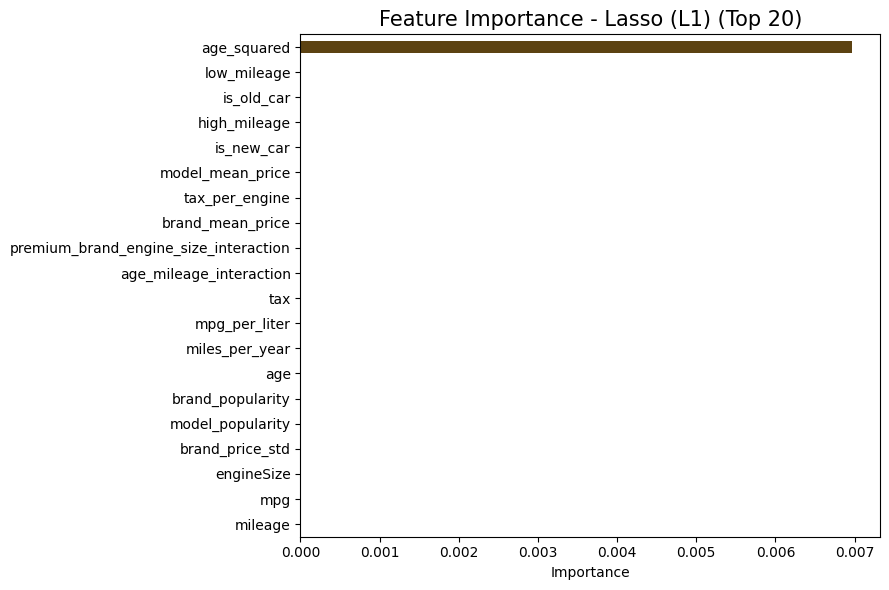


------------------------------------------------------------
MODEL: Lasso (L1)
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



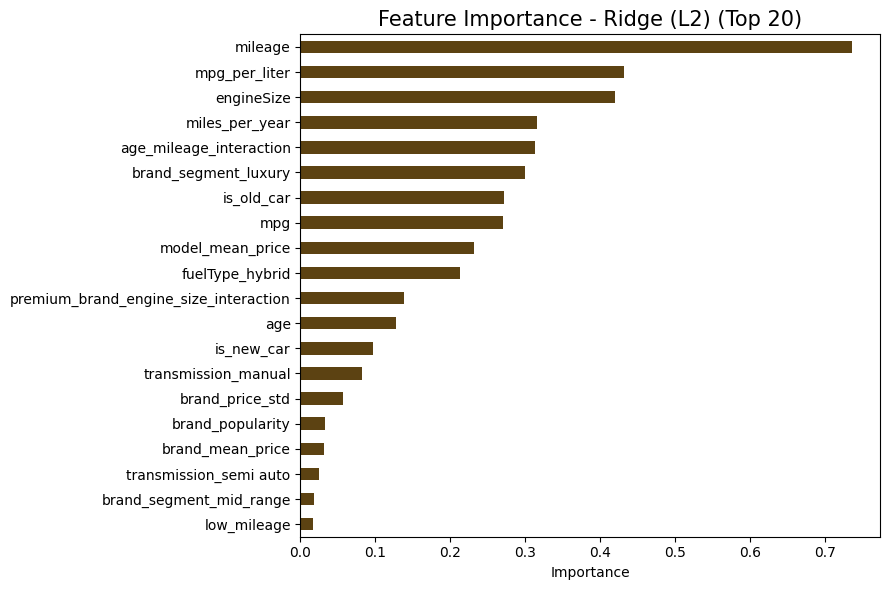


------------------------------------------------------------
MODEL: Ridge (L2)
Threshold: 0.1605
Selected: 10 features
Features: ['mileage', 'mpg', 'engineSize', 'miles_per_year', 'age_mileage_interaction', 'mpg_per_liter', 'model_mean_price', 'is_old_car', 'fuelType_hybrid', 'brand_segment_luxury']
------------------------------------------------------------



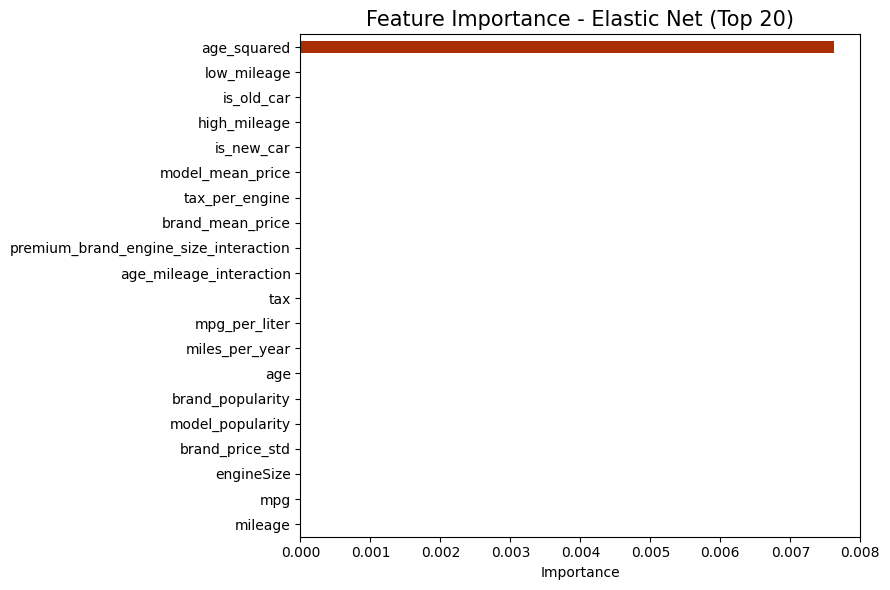


------------------------------------------------------------
MODEL: Elastic Net
Threshold: 0.0003
Selected: 1 features
Features: ['age_squared']
------------------------------------------------------------



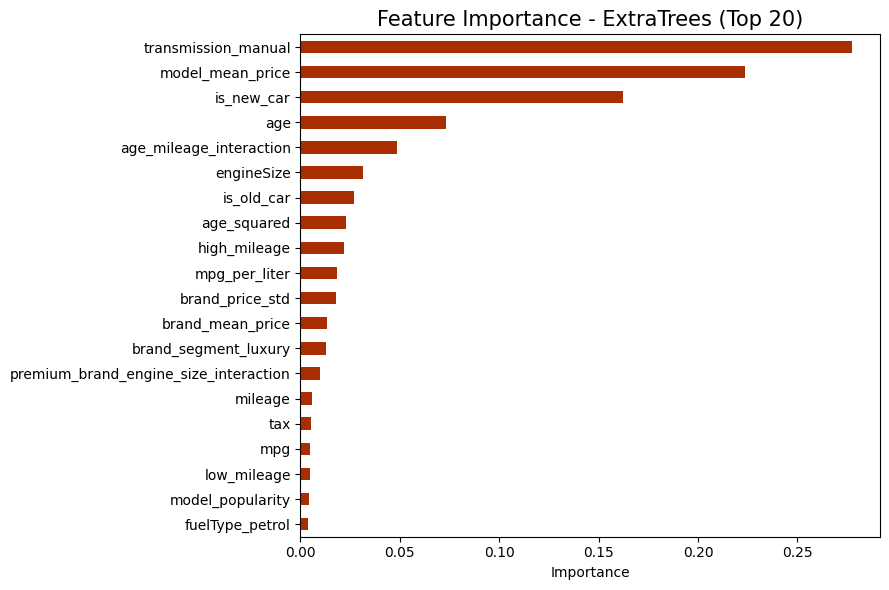


------------------------------------------------------------
MODEL: ExtraTrees
Threshold: 0.0385
Selected: 5 features
Features: ['transmission_manual', 'model_mean_price', 'is_new_car', 'age', 'age_mileage_interaction']
------------------------------------------------------------



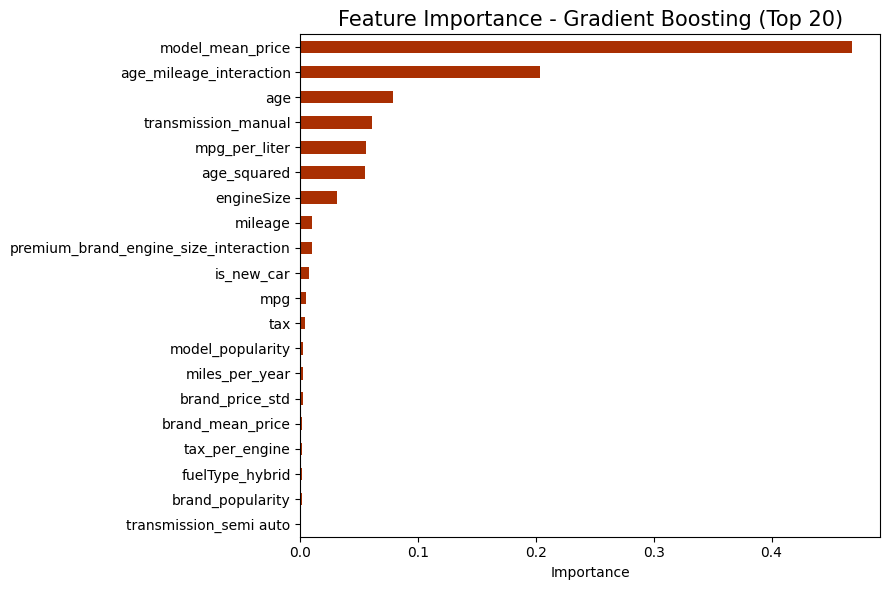


------------------------------------------------------------
MODEL: Gradient Boosting
Threshold: 0.0385
Selected: 6 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'transmission_manual', 'mpg_per_liter', 'age_squared']
------------------------------------------------------------



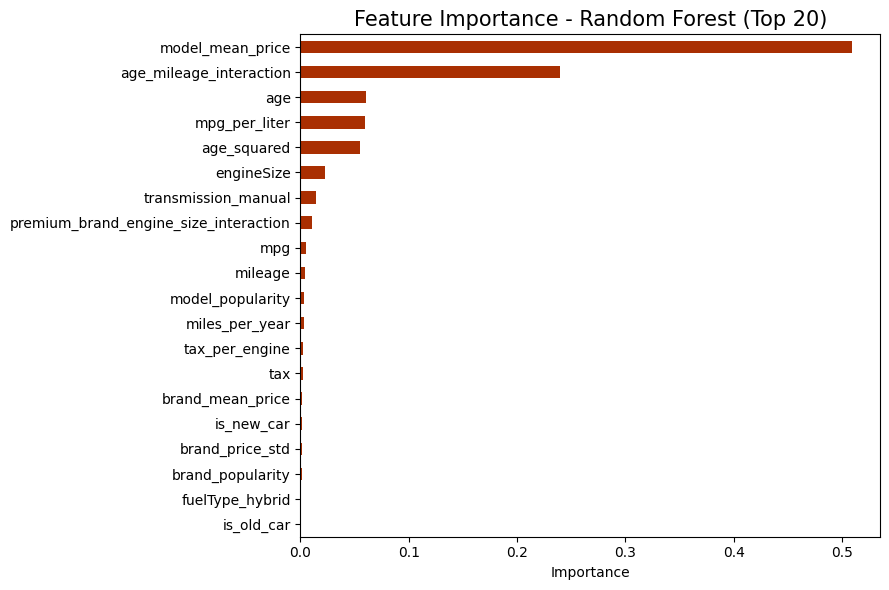


------------------------------------------------------------
MODEL: Random Forest
Threshold: 0.0385
Selected: 5 features
Features: ['model_mean_price', 'age_mileage_interaction', 'age', 'mpg_per_liter', 'age_squared']
------------------------------------------------------------



['model_mean_price',
 'age_mileage_interaction',
 'age',
 'mpg_per_liter',
 'age_squared']

In [10]:
# Plot feature importance
utils.plot_importance_unified(palette, abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
utils.print_selection_results(abs(lasso_coefs), "Lasso (L1)")

utils.plot_importance_unified(palette, abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
utils.print_selection_results(abs(ridge_coefs), "Ridge (L2)")

utils.plot_importance_unified(palette, elasticnet_importance, "Elastic Net", is_tree_model=True)
utils.print_selection_results(elasticnet_importance, "Elastic Net")

utils.plot_importance_unified(palette, et_importance, "ExtraTrees", is_tree_model=True)
utils.print_selection_results(et_importance, "ExtraTrees")

utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.print_selection_results(gb_importance, "Gradient Boosting")

utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.print_selection_results(rf_importance, "Random Forest")

### 2.6 Optimal Feature Set Selection

We test different numbers of top-ranked features to find the optimal subset that balances model complexity with predictive performance.

In [11]:
# Create ranks for each model (1 = most important)
elasticnet_ranks = pd.Series(range(1, len(elasticnet_importance) + 1), index=elasticnet_importance.index)
et_ranks = pd.Series(range(1, len(et_importance) + 1), index=et_importance.index)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)

# Combine and sort
feature_ranks = (elasticnet_ranks + et_ranks + gb_ranks + rf_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'ELASTICNET': lambda: ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=37, max_iter=10000),
    'ET': lambda: ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1),
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1),
    'MLP': lambda: MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                                 alpha=0.01, learning_rate='adaptive', max_iter=500,
                                 early_stopping=True, random_state=37)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}


feature_range = range(1, len(ranked_features) + 1)

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f} | MLP: {best_results['MLP']['val_history'][-1]:,.0f}")


['age', 'age_mileage_interaction', 'age_squared', 'model_mean_price', 'engineSize', 'mpg_per_liter', 'transmission_manual', 'mileage', 'mpg', 'premium_brand_engine_size_interaction', 'is_new_car', 'brand_price_std', 'model_popularity', 'tax', 'miles_per_year', 'brand_mean_price', 'tax_per_engine', 'brand_popularity', 'is_old_car', 'high_mileage', 'brand_segment_luxury', 'fuelType_hybrid', 'fuelType_petrol', 'low_mileage', 'transmission_semi auto', 'brand_segment_mid_range']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 5,500 | GB: 5,500 | RF: 5,500 | KNN: 5,759 | MLP: 5,505
n= 2 | ElasticNet: 6,810 | ExtraTrees: 5,401 | GB: 5,391 | RF: 5,406 | KNN: 5,770 | MLP: 5,424
n= 3 | ElasticNet: 6,250 | ExtraTrees: 5,401 | GB: 5,391 | RF: 5,406 | KNN: 5,795 | MLP: 5,477
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,377 | GB: 2,177 | RF: 2,181 | KNN: 2,229 | MLP: 2,506
n= 5 | ElasticNet: 6,250 | ExtraTrees: 1,960 | GB: 1,661 | RF: 1,627 | KNN: 1,709 | MLP: 2,145
n= 

Based on the feature importance analysis, we focus on selecting features that are consistently ranked as important by our top-performing models (Gradient Boosting and Tandom Forest).

In [12]:
final_features = [#'age',
                   'age_squared', 
                  #'age_mileage_interaction', 
                   'model_mean_price', 
                   'engineSize', 
                   'mpg_per_liter', 
                   'transmission_manual',
                   'mileage', 
                   'mpg',
                   'premium_brand_engine_size_interaction', 
                   #'is_new_car', 
                   'brand_price_std', 
                   'model_popularity', 
                   'tax', 
                   #'miles_per_year', 
                   'brand_mean_price', 
                   'tax_per_engine', 
                   'brand_popularity', 
                   'is_old_car', 
                   #'high_mileage', 
                   'fuelType_hybrid', 
                   #'brand_segment_luxury', 
                   'fuelType_petrol', 
                   #'low_mileage', 
                   #'transmission_semi auto', 
                   'brand_segment_mid_range']

In [13]:
final_features_sorted_rf = (
    rf_importance
    .loc[final_features]
    .sort_values(ascending=False)
    .index
    .tolist()
)

print(final_features_sorted_rf)

feature_range = range(1, len(final_features)+1)

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features_sorted_rf,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features_sorted_rf[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_log)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, np.expm1(model.predict(X_train_scaled[features])))
        val_mae = mean_absolute_error(y_val_array, np.expm1(model.predict(X_val_scaled[features])))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | ElasticNet: {best_results['ELASTICNET']['val_history'][-1]:,.0f} | ExtraTrees: {best_results['ET']['val_history'][-1]:,.0f} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f} | MLP: {best_results['MLP']['val_history'][-1]:,.0f}")


['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 1 | ElasticNet: 6,810 | ExtraTrees: 4,356 | GB: 4,351 | RF: 4,351 | KNN: 4,494 | MLP: 4,377
n= 2 | ElasticNet: 6,810 | ExtraTrees: 3,786 | GB: 2,967 | RF: 2,471 | KNN: 2,434 | MLP: 3,848
n= 3 | ElasticNet: 6,250 | ExtraTrees: 2,440 | GB: 1,743 | RF: 1,573 | KNN: 1,595 | MLP: 2,397
n= 4 | ElasticNet: 6,250 | ExtraTrees: 2,274 | GB: 1,661 | RF: 1,525 | KNN: 1,547 | MLP: 2,281
n= 5 | ElasticNet: 6,250 | ExtraTrees: 2,194 | GB: 1,615 | RF: 1,494 | KNN: 1,520 | MLP: 2,171
n= 6 | ElasticNet: 6,250 | ExtraTrees: 2,156 | GB: 1,615 | RF: 1,487 | KNN: 1,518 | MLP: 2,309
n= 7 | ElasticNet: 6,250 | ExtraTrees: 2,123 | GB: 1,59

**Final Feature Selection:** Based on the analysis above, we select the top **14 features** for our models (but removed features thar we saw that were making the main models worst) This number represents the optimal trade-off between model complexity and predictive performance, as validated through cross-validation experiments.


Plotting feature selection results...



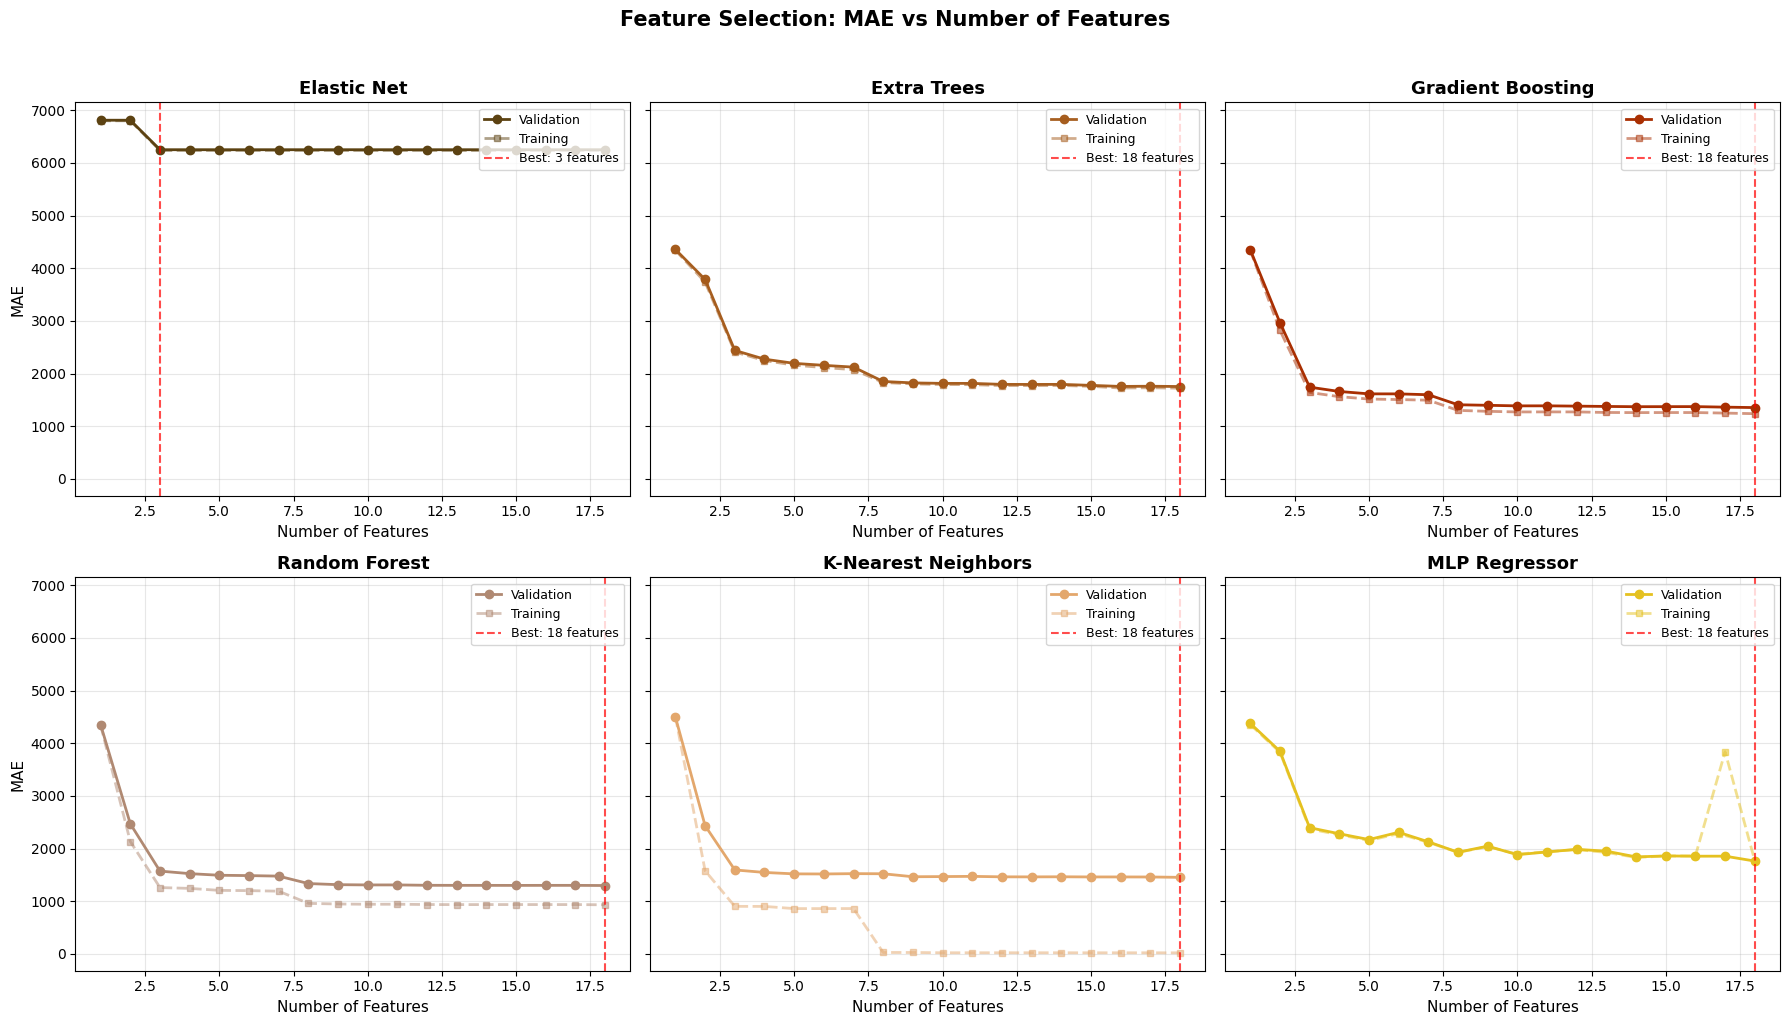

In [14]:
print("\nPlotting feature selection results...\n")

# X-axis: number of features tested
n_values = list(feature_range)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()  # Flatten 2D array to 1D for easier iteration

# (key_in_dict, plot_title, palette_color_index)
plots_config = [
    ("ELASTICNET", "Elastic Net", 0),
    ("ET",         "Extra Trees", 2),
    ("GB",         "Gradient Boosting", 1),
    ("RF",         "Random Forest", 3),
    ("KNN",        "K-Nearest Neighbors", 4),
    ("MLP",        "MLP Regressor", 5),
]

for ax, (model_key, title, color_idx) in zip(axes, plots_config):
    train_history = best_results[model_key]["train_history"]
    val_history = best_results[model_key]["val_history"]
    best_n = best_results[model_key]["best_n"]

    # Validation MAE
    ax.plot(
        n_values, val_history,
        marker="o", linewidth=2, markersize=6,
        color=palette[color_idx], label="Validation"
    )

    # Training MAE
    ax.plot(
        n_values, train_history,
        marker="s", linewidth=2, markersize=4,
        color=palette[color_idx], alpha=0.5,
        linestyle="--", label="Training"
    )

    # Best number of features (vertical line)
    ax.axvline(
        best_n, color="red", linestyle="--", alpha=0.7,
        label=f"Best: {int(best_n)} features"
    )

    ax.set_xlabel("Number of Features", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Shared Y label
axes[0].set_ylabel("MAE", fontsize=11)
axes[3].set_ylabel("MAE", fontsize=11)

plt.suptitle("Feature Selection: MAE vs Number of Features", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [15]:
print(final_features_sorted_rf)

['model_mean_price', 'mpg_per_liter', 'age_squared', 'engineSize', 'transmission_manual', 'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'model_popularity', 'tax_per_engine', 'tax', 'brand_mean_price', 'brand_price_std', 'brand_popularity', 'fuelType_hybrid', 'is_old_car', 'brand_segment_mid_range', 'fuelType_petrol']


In [16]:
selected_features = ['model_mean_price', 'model_popularity', 
                     'brand_mean_price','premium_brand_engine_size_interaction', 
                     'engineSize', 'mpg', 'mileage', 'tax',
                     'mpg_per_liter', 'age_squared', 'tax_per_engine',
                     'transmission_manual', 'fuelType_hybrid', 'fuelType_petrol']

<a id='3-benchmarking'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

### 3.1 Model Assessment Strategy and Metrics


Following the **"No Free Lunch" theorem**, which suggests that no single algorithm is universally superior for all problems, we implemented a multi-stage benchmarking strategy. We explored five distinct algorithm families covered in classes: **Linear Models (Elastic Net)**, **Distance-based models (K-Nearest Neighbors)**, **Neural Networks (MLP Regressor)**, and **Ensemble methods** including both **Bagging (Random Forest, Extra Trees)** and **Boosting (Gradient Boosting)**.

As we have already seen, we adopted a **Holdout validation strategy**, partitioning the data into training and validation sets. This approach ensured a strict separation of data, preventing **Data Leakage** during the preprocessing, feature selection and hyperparameter optimization phases. To finalize the process, we utilized **Stacked Generalization** (Stacking), which incorporates an internal **5-fold Cross-Validation** mechanism to calibrate the meta-estimator, ensuring robust weight allocation without compromising the primary holdout integrity.

<br>

To evaluate model performance, all predictions were transformed from the logarithmic training scale back to the original currency (£) using the inverse function ($exp(x)-1$). The following metrics were selected:

* **Mean Absolute Error (MAE):** Our primary optimization metric. It provides a robust and interpretable measure of the average prediction error in pounds (£). It ensures that extreme values do not disproportionately bias the model's parameters, maintaining focus on the most frequent market transactions.

* **Root Mean Squared Error (RMSE):** While we prioritized the median price, we recognized that large errors in high-value cars are financially impactful. RMSE was used as a secondary stability metric. It penalizes larger errors more severely, ensuring the selected model does not produce catastrophic mispricing for specific vehicle segments.

* **Pinball Loss (\alpha=0.3)** [asymmetric Quantile Loss] A business-centric asymmetric metric. By setting \alpha=0.3, we penalized **overestimation** (predicting a price higher than the actual value) more heavily than underestimation. This aligns with the business goal of ensuring Cars 4 You does not overpay for inventory, thereby protecting profit margins.

*Note*: The `evaluate_model` function is included here instead of `util.py` to provide a clear view of the key performance metrics and although the model predictions are made on the log-transformed scale internally, all reported metrics are *converted back to the original price scale (£)*. This ensures that the results are directly interpretable in terms of actual car prices.


In [17]:
def evaluate_model(model, X_train, y_train_original, X_val, y_val_original):
    """
    Evaluate the model and return various metrics on original scale (£)

    Parameters
    ----------
    model : sklearn estimator
        The trained model to evaluate.
    X_train : pd.DataFrame
        Training features.
    y_train_original : np.array
        Original training target values (not log-transformed).
    X_val : pd.DataFrame
        Validation features.
    y_val_original : np.array
        Original validation target values (not log-transformed).

    Returns
    -------
    dict
        A dictionary containing MAE, RMSE, and Pinball Loss for both training and validation sets.    
    """

    # Predict on log scale
    y_train_pred_log = model.predict(X_train)
    y_val_pred_log = model.predict(X_val)
    
    # Transform predictions back to original scale (£) in order to calculate interpretable metrics
    y_train_pred = np.expm1(y_train_pred_log)
    y_val_pred = np.expm1(y_val_pred_log)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train_original, y_train_pred),
        'Val MAE': mean_absolute_error(y_val_original, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train_original, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val_original, y_val_pred),
        'Train Pinball (α=0.3)': mean_pinball_loss(y_train_original, y_train_pred, alpha=0.3),
        'Val Pinball (α=0.3)': mean_pinball_loss(y_val_original, y_val_pred, alpha=0.3)
    }
    return scores

### 3.2 Model Configuration, Hyperparameter Search and Results

Our optimization strategy was structured in two distinct phases to balance computational efficiency with model robustness, moving from a broad architectural screening to granular hyperparameter refinement.

**Phase 1: Hybrid Benchmarking** <BR>
 We performed an initial screening using **Manual Random Search**, testing up to 4 random hyperparameter combinations for each of the five families.

 **Gradient Boosting** was the clear frontrunner. It achieved the best results across all validation metrics (**MAE, RMSE, and Pinball Loss**). It demonstrated a somewhat healthy balance between bias and variance; unlike other high-performing models like **K-Nearest Neighbors**, it did not exhibit extreme overfitting, maintaining a realistic generalization ratio.

**K-Nearest Neighbors** produced competitive validation scores, but the model exhibited a near-zero training error (Ratio of 0.01), a clear indicator that the model was over-reliant on specific training coordinates rather than learning a generalizable pricing logic, making it unsuitable for a production environment.

The Tree-Based Ensemble (**Extra Trees** vs. **Random Forest**) showed strong predictive capabilities, significantly outperforming the linear and neural network baselines. **Extra Trees** achieved slightly superior validation metrics compared to Random Forest. However, it also displayed a higher overfitting ratio (none of them overfit at all).

In [18]:
# Model configurations and hyperparameter grids (for a manual Random Search)
models_and_grids = {
    "Elastic Net": {
        "model": ElasticNet(random_state=37, max_iter=2000, tol=0.001),
        "params": {
             'alpha': [0.01, 1, 10], # regularization strength
             'l1_ratio': [0.75, 0.5, 0.25] #focus more on l1_ratio or not
        } 
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1, algorithm='ball_tree'), #ball_tree to speed up
        "params": {
            'n_neighbors': [100, 500], # number of neighbors
            'weights': ['distance', 'uniform'], #weight of each neighbor
            'p': [1, 2],  #distance metric: 1 for manhattan, 2 for euclidean
        }
    },
    "MLPRegressor": {
        "model": MLPRegressor(random_state=37, max_iter=1500, early_stopping=True,tol= 0.001, n_iter_no_change=15),
        "params": {
            "hidden_layer_sizes": [(15,10,7,3), (34, 15, 5)], #following more or less the rule of thumbs we learned in class, this should be ok
            #it a common practice to start with layers that funnel down and also multiple layers (depth) are generally better than a single very wide layer
            "activation": ["relu", "tanh"], #relu: computationally efficient, helps avoid vanishing gradient problem; tanh: zero-centered, which can help in learning
            "alpha": [0.01, 0.001], #to prevent overfitting
            "batch_size": [128, 256], # a little bigger batches to speed up
        
            "solver": ["adam", "sgd"], # adam: adaptive learning rates, good for most cases; sgd: can be more stable with the right settings (more control)
            "learning_rate_init": [0.001, 0.01], #initial learning rate shouldn't be too high to avoid overshooting minima or too low to avoid slow convergence 

            #ADAM specific parameters
            "beta_1": [0.9], #decay rate for the first moment estimates
            "beta_2": [0.999], #decay rate for the second moment estimates

            #SGD specific parameters
            "learning_rate": ['adaptive'], #adaptive: keeps the learning rate constant as long as training loss decreases
            "momentum": [0.9], #helps accelerate gradients vectors in the right directions, thus leading to faster converging
            "nesterovs_momentum": [True]
        }
    },
    # We know that Decision Trees are usually not strong standalone models (high error, high variance, low stability, and high sensitivity to noise),
    # so we will not use them directly. But this is exactly where ensemble learning methods (bagging, boosting,...) come in.

    # Bagging ensemble method that uses random splits based on Decision Trees:
    "Extra Tree": {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False), # the split is already random, we don't need bootstrap samples
        "params": {
            'n_estimators': [250, 500], #number of models trained in parallel, we choose high numbers so hopefully it won't overfit and make the result more trustworthy
            'max_depth': [15, 20], # not too deep to avoid overfitting
            'min_samples_leaf': [15, 30], # to make sure each leaf has enough samples (not too specific)
            'max_features': ['sqrt', 0.8] # to introduce randomness and reduce correlation between trees
        }
    },
    #Bagging ensemble method that uses bootstrap samples and bootstrap feature subsets based on Decision Trees
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1, max_samples=0.7),
        "params": {
            'n_estimators': [300, 500], #number of trees is high to prevent overfitting and improve stability
            'max_features': ['sqrt', 1], #use subsets of features to reduce correlation between trees or use all features
            'max_depth': [15, 20], #not too deep to avoid overfitting
            'min_samples_split': [90,120], #to ensure each split has enough samples
            'min_samples_leaf': [15,30], #to ensure each leaf has enough samples
        }
    },
    # Ensemble of sequential trees, each correcting previous errors,combined via weighted sum (learning rate)
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            'learning_rate': [0.01, 0.05], # low for stability
            'max_depth': [5, 8], # low depth for weak learners
            'n_estimators': [500, 1000], #to compensate for low learning rate
            'subsample': [0.75, 0.85], # subsampling for regularization (anti-overfitting)
            'max_features': ['sqrt', 0.8], # to introduce randomness and reduce correlation between trees
            'min_samples_leaf': [15, 30] # hopefully sufficient high values to prevent overfitting
        }
    },
}

In [19]:
# easier names
y_train_original_for_eval = y_train_array 
y_val_original_for_eval = y_val_array
y_train_log_for_fit = y_train_log

########################################################
# 1: hybrid benchmarking (MANUAL RANDOM SEARCH)        #
########################################################
results_list = []

print("PHASE 1: Initial benchmarking with Manual Random Search")
print("="*80)

# Loop through each model and its hyperparameter grid
for model_name, config in models_and_grids.items():
    print(f"\n---> Optimizing {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]
    
    # Generate all possible parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())

    # Select at most 4 random combinations to test
    if len(param_combinations) > 4:
        tested_params = random.sample(param_combinations, 4)
        print(f"Testing 4 random combinations out of {len(param_combinations)}:\n")
    else:
        tested_params = param_combinations
        print(f"Testing all {len(param_combinations)} combinations:\n")

    # track the best model and its metrics
    best_val_mae = float('inf')
    best_result = None

    # Loop through the parameters
    for values in tested_params:
        params = dict(zip(param_keys, values))
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_log_for_fit) # fit on log-price
        
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval) #gets scores in original scale (£)

        # the model with the lowest Val MAE is considered the best model for that family algorithm
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores,
                }
            
            # Check for overfitting
            overfit_ratio = scores['Train MAE'] / scores['Val MAE']
            if overfit_ratio < 0.75:
                print(f"    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: {overfit_ratio:.2f} !!!")
            print(f"  New best: {params} | VAL MAE:{scores['Val MAE']:,.2f} | Pinball(0.3):{scores['Val Pinball (α=0.3)']:.2f} | Val RMSE:{scores['Val RMSE']:.2f} ")

    # only adds the best VAL MAE result of each model to the phase 1 results list
    if best_result:
        results_list.append(best_result)

   
# Final results phase 1 DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*80)
print("Final benchmarking results per model (phase 1):")
display(results_df[['Model','Train MAE', 'Val MAE','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])

# Get the best parameters from phase 1 for use in phase 2
best_params_phase1 = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params_phase1[model_name] = eval(params_str)

print("\nOptimized Parameters from Phase 1:")
for name, params in best_params_phase1.items():
    print(f" - {name}: {params}")

PHASE 1: Initial benchmarking with Manual Random Search

---> Optimizing Elastic Net
Testing 4 random combinations out of 9:

  New best: {'alpha': 0.01, 'l1_ratio': 0.5} | VAL MAE:2,323.87 | Pinball(0.3):1082.16 | Val RMSE:3972.12 
  New best: {'alpha': 0.01, 'l1_ratio': 0.25} | VAL MAE:2,302.58 | Pinball(0.3):1077.16 | Val RMSE:3925.56 

---> Optimizing KNeighbors
Testing 4 random combinations out of 8:

  New best: {'n_neighbors': 500, 'weights': 'uniform', 'p': 2} | VAL MAE:2,358.15 | Pinball(0.3):1028.45 | Val RMSE:4204.29 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 500, 'weights': 'distance', 'p': 1} | VAL MAE:1,875.79 | Pinball(0.3):835.99 | Val RMSE:3571.63 
    !!! OVERFITTING: Train MAE/Val MAE Ratio < 0.75: 0.01 !!!
  New best: {'n_neighbors': 100, 'weights': 'distance', 'p': 1} | VAL MAE:1,578.28 | Pinball(0.3):735.59 | Val RMSE:2974.85 

---> Optimizing MLPRegressor
Testing 4 random combinations out of 64:

  New best: {'hidde

,Model,Train MAE,Val MAE,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
5,GradientBoosting,1170.874921,1309.125574,553.328341,619.084814,2211.675248,2312.903450,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
3,Extra Tree,1431.959816,1508.462390,662.668292,701.007640,2668.987074,2724.989953,"{'n_estimators': 500, 'max_depth': 20, 'min_sa..."
1,KNeighbors,20.976849,1578.280319,10.313208,735.589108,206.370471,2974.851685,"{'n_neighbors': 100, 'weights': 'distance', 'p..."
4,RandomForest,1550.302289,1596.199821,705.105003,727.317915,2937.290013,2986.127240,"{'n_estimators': 300, 'max_features': 'sqrt', ..."
2,MLPRegressor,1701.751603,1727.351669,799.214827,813.299740,3051.135938,3076.119484,"{'hidden_layer_sizes': (34, 15, 5), 'activatio..."
0,Elastic Net,2328.949119,2302.584894,1086.462084,1077.155326,4036.036147,3925.558906,"{'alpha': 0.01, 'l1_ratio': 0.25}"



Optimized Parameters from Phase 1:
 - GradientBoosting: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30}
 - Extra Tree: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 15, 'max_features': 0.8}
 - KNeighbors: {'n_neighbors': 100, 'weights': 'distance', 'p': 1}
 - RandomForest: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 20, 'min_samples_split': 90, 'min_samples_leaf': 15}
 - MLPRegressor: {'hidden_layer_sizes': (34, 15, 5), 'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'solver': 'adam', 'learning_rate_init': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'learning_rate': 'adaptive', 'momentum': 0.9, 'nesterovs_momentum': True}
 - Elastic Net: {'alpha': 0.01, 'l1_ratio': 0.25}


We implemented a structured “Quality Funnel” to select our two finalists for Phase 2, prioritizing models that were both accurate and reliable.

* **Step 0: Integrity Filter (Severe Overfitting)**
  The primary priority was eliminating "memory-based" learning. Models with a Generalization Ratio ($\text{MAE}_{\text{train}} / \text{MAE}_{\text{val}} < 0.50$) were eliminated, removing K-Nearest Neighbors.
  
* **Step 1: Predictive Performance Screening (MAE)**
  Bottom performers on validation MAE (Elastic Net and MLP) were discarded, focusing on high-potential ensemble methods.

* **Step 2: Outlier Robustness (RMSE)**
  Among Gradient Boosting, Extra Trees, and Random Forest, the model with the highest validation RMSE (Random Forest) was removed. It didn't need to go to the third step where the model with the highest Pinball Loss would be removed.

The two finalists selected for Phase 2 are **Gradient Boosting** and **Extra Trees**.<br>

While Extra Trees showed a higher initial overfit than Random Forest, we proceeded with it based on its higher predictive ceiling. Our strategy assumes that residual variance will be mitigated during *Phase 2* (Granular Fine-Tuning) and through the Stacked Generalization in *Phase 3*, which acts as a powerful regularizer by weighting models based on their out-of-fold performance.

In [20]:
df_selection = results_df.copy()

# 0. Severe Overfitting Filter (Ratio >= 0.5)
initial_count = len(df_selection)
df_selection['Ratio_Phase1'] = df_selection['Train MAE'] / df_selection['Val MAE']
df_selection = df_selection[df_selection['Ratio_Phase1'] >= 0.5]

if len(df_selection) < initial_count:
    discarded = results_df[~results_df.index.isin(df_selection.index)]['Model'].tolist()
    print(f"\nStep 0: Discarded {initial_count - len(df_selection)} models due to severe Overfitting (Ratio < 0.5): {discarded}")

#      Making we have 2 models to proceed
# 1. Discard by MAE: it only discards 2 if there are at least 5 models
if len(df_selection) > 4:
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(len(df_selection) - 2)
    print(f"Step 1: Discarded 2 models (worst MAE). Remaining: {df_selection['Model'].tolist()}")
elif len(df_selection) == 4: # If there are exactly 4, just discard 1
    df_selection = df_selection.sort_values('Val MAE', ascending=True).head(3)
    print(f"Step 1: Discarded 1 model (worst MAE). Remaining: {df_selection['Model'].tolist()}")

# 2. Discard by RMSE: it only discards 1 if there are more than 2 models
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val RMSE', ascending=True).head(len(df_selection) - 1)
    print(f"Step 2: Discarded 1 model (worst RMSE). Remaining: {df_selection['Model'].tolist()}")

# 3. Final Selection by Pinball: if still more than 2
if len(df_selection) > 2:
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True).head(2)
    print(f"Step 3: Selected best 2 by Pinball. Remaining: {df_selection['Model'].tolist()}")
else:
    # Se já só tiveres 2, apenas garante que estão ordenados
    df_selection = df_selection.sort_values('Val Pinball (α=0.3)', ascending=True)

# Top 2 models selected
top_2_models = df_selection['Model'].tolist()
print(f"The {len(top_2_models)} models selected for phase 2 (Refinement/Stacking) are: {top_2_models}")


Step 0: Discarded 1 models due to severe Overfitting (Ratio < 0.5): ['KNeighbors']
Step 1: Discarded 2 models (worst MAE). Remaining: ['GradientBoosting', 'Extra Tree', 'RandomForest']
Step 2: Discarded 1 model (worst RMSE). Remaining: ['GradientBoosting', 'Extra Tree']
The 2 models selected for phase 2 (Refinement/Stacking) are: ['GradientBoosting', 'Extra Tree']


**Phase 2: Fine-Tuning and Risk Mitigation**<br>
The top two candidates (**Gradient Boosting** and **Extra Trees**) underwent a more granular optimization focusing on generalization and stability. We enforced strict constraints for any model update:

1. **Anti-Overfitting Filter:** Any configuration with a Training/Validation MAE ratio below **0.75** was rejected.

2. **Stability Check:** New configurations were only accepted if they improved the MAE without degrading the RMSE by more than **5%** or the Pinball Loss by more than **10%** to the current best performing model in the sequence.

In [21]:
#######################################################################
# 2: more refined optimization focusing on top 2 and anti-overfitting #
#######################################################################
# new grids for the winners of phase 1
models_and_grids_phase2 = {}

if "GradientBoosting" in top_2_models:
    models_and_grids_phase2["GradientBoosting"] = {
        "model": GradientBoostingRegressor(random_state=37, loss='absolute_error'),
        "params": {
            # Explore a bit around the best params found in phase 1
            'learning_rate': [0.03, 0.05, 0.07], # explore a bit around 0.05
            'max_depth': [7, 8, 9], #explore a bit around depth 8; if 7 is selected, it might reduce overfitting
            'n_estimators': [500, 800, 1000], #add 800 to have a middle ground
            'subsample': [0.8, 0.85, 0.9], #explore a bit around 0.85
            'min_samples_leaf': [25, 30, 35] #explore a bit around 30 (not 15 as before) to prevent overfitting
        }
    }

if "Extra Tree" in top_2_models:
    models_and_grids_phase2["Extra Tree"] = {
        "model": ExtraTreesRegressor(random_state=37, n_jobs=-1, bootstrap=False),
        "params": {
            # Explore a bit around the best params found in phase 1
            'n_estimators': [500, 600, 700], #choosing higher values that before to deminish variance
            'max_depth': [18, 20, 22, 25], #explore a bit around 20; higher depth might bring a little overfitting...but we will control it with min_samples_leaf and evenually with stacking
            'min_samples_leaf': [10, 15, 20], #explore a bit around 15
            'max_features': [0.7, 0.8, 0.9] #explore a bit around 0.8. 0.7 introduces randomness and reduce correlation between trees while 0.9 allows each tree to have more information but risk overfitting (but we are currently good on overfitting)
        }
    }

# Optimization Loop for Phase 2
results_list_phase2 = []
print("\nPHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)")
print("="*80)

for model_name, config in models_and_grids_phase2.items():
    print(f"\n---> Refinement: {model_name}")
    
    X_tr = X_train_scaled[selected_features]
    X_vl = X_val_scaled[selected_features]

    # Initialize with the Phase 1 best model
    best_params_f1 = best_params_phase1[model_name]
    model_f1 = clone(config['model']).set_params(**best_params_f1)
    model_f1.fit(X_tr, y_train_log_for_fit)
    
    # Scores for comparison
    best_scores_p2 = evaluate_model(model_f1, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
    best_val_mae_p2 = best_scores_p2['Val MAE']
    curr_best_rmse = best_scores_p2['Val RMSE']
    curr_best_pinball = best_scores_p2['Val Pinball (α=0.3)']
    
    best_result_phase2 = {
        'Model': model_name,
        'Best Params': str(best_params_f1),
        'MAE_Ratio': best_scores_p2['Train MAE'] / best_scores_p2['Val MAE'],
        'Source': 'Phase 1 Winner',
        **best_scores_p2,
    }
    
    print(f"  Base (Phase 1): {best_params_f1} | MAE: {best_val_mae_p2:,.2f}")

    # Try 10 new random parameter combinations
    param_combinations = list(product(*config['params'].values()))
    param_keys = list(config['params'].keys())
    tested_params = random.sample(param_combinations, min(len(param_combinations), 10))
    
    for values in tested_params:
        params = dict(zip(param_keys, values))
        if params == best_params_f1: continue
            
        model = clone(config['model']).set_params(**params)
        model.fit(X_tr, y_train_log_for_fit)
        scores = evaluate_model(model, X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)
        
        ovf_ratio = scores['Train MAE'] / scores['Val MAE']
        
        # I. Anti-Overfitting Filter (Ratio > 0.75)
        if ovf_ratio < 0.75:
            print(f"   [REJECTED - OVF] Ratio: {ovf_ratio:.2f} | Params: {params}")
            continue
            
        # II. Stability check (RMSE < 5% degradation, Pinball < 10%)
        rmse_limit = curr_best_rmse * 1.05
        pinball_limit = curr_best_pinball * 1.10
        
        if scores['Val RMSE'] > rmse_limit or scores['Val Pinball (α=0.3)'] > pinball_limit:
            print(f"   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {params}")
            continue

        # III. Update if MAE is better
        if scores['Val MAE'] < best_val_mae_p2:
            best_val_mae_p2 = scores['Val MAE']
            curr_best_rmse = scores['Val RMSE']
            curr_best_pinball = scores['Val Pinball (α=0.3)']
            
            best_result_phase2 = {
                'Model': model_name,
                'Best Params': str(params),
                'MAE_Ratio': ovf_ratio,
                'Source': 'Phase 2 Improvement',
                **scores,
            }
            print(f" New Improvement Found for {model_name}:")
            print(f" Train MAE: {scores['Train MAE']:,.2f} | Val MAE: {scores['Val MAE']:,.2f}")
            print(f" Train Pinball: {scores['Train Pinball (α=0.3)']:,.2f} | Val Pinball: {scores['Val Pinball (α=0.3)']:,.2f}")
            print(f" Train RMSE: {scores['Train RMSE']:,.2f} | Val RMSE: {scores['Val RMSE']:,.2f}")
            print(f" Overfitting Ratio: {ovf_ratio:.2f}\n")

    results_list_phase2.append(best_result_phase2)

# Final Results Visualization
results_df_phase2 = pd.DataFrame(results_list_phase2).sort_values('Val MAE')
display(results_df_phase2[['Model','Train MAE', 'Val MAE','MAE_Ratio','Train Pinball (α=0.3)', 'Val Pinball (α=0.3)','Train RMSE', 'Val RMSE', 'Best Params']])



PHASE 2: More Fine-Tuning & Exploration (Top Models: GB & Extra Trees)

---> Refinement: GradientBoosting
  Base (Phase 1): {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.85, 'max_features': 0.8, 'min_samples_leaf': 30} | MAE: 1,309.13
 New Improvement Found for GradientBoosting:
 Train MAE: 1,078.53 | Val MAE: 1,270.62
 Train Pinball: 511.01 | Val Pinball: 602.68
 Train RMSE: 2,051.82 | Val RMSE: 2,231.86
 Overfitting Ratio: 0.85

   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 800, 'subsample': 0.9, 'min_samples_leaf': 30}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8, 'min_samples_leaf': 35}
   [REJECTED - STABILITY] MAE might be better, but RMSE/Pinball degraded too much. Params: {'learning_rate': 0.03, 'max_depth': 7, 'n_estimators':

,Model,Train MAE,Val MAE,MAE_Ratio,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
0,GradientBoosting,1078.532941,1270.620871,0.848824,511.014940,602.682437,2051.823565,2231.864640,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
1,Extra Tree,1310.773196,1430.519413,0.916292,611.592695,670.735605,2416.000602,2542.727737,"{'n_estimators': 500, 'max_depth': 22, 'min_sa..."


For **Gradient Boosting**, we achieved a refined validation MAE of **1,270.62** (compared to the previous 1,309.13) with just a little more overfit but nothing special (current overfit ratio: 1,078.53/1,270.62=85%; before:1170.87/1309.13=89%). Several configurations didn't achieve better validation MAE or even if they did, they were rejected because they significantly increased the RMSE (stability) or Pinball Loss (business risk).

For **Extra Trees**, we improved the validation MAE from 1508.46 to **1,430.52** with a little worse overfitting ratio (current: 1,310.77/1,430.51=92%; before:1,431.96/1,508.46=95%). With this model there were actually more actual improvements with less rejections than with Gradient Boosting.

What if if try to combine both models, could we possibly get better results? This is what we did in the next section.

---

To capitalize on the diverse learning mechanisms of our finalists, we built a **Stacking Regressor**. This ensemble used the optimized **Gradient Boosting** (Boosting) and **Extra Trees** (Bagging) as base estimators. A **Ridge Regressor** (\alpha=10.0) was employed as the meta-estimator (final judge). The meta-estimator was trained using **out-of-fold predictions** via internal 5-fold cross-validation to ensure the weights were assigned based on true generalization capability.

In [22]:
###############################################
# 3: Stacking Benchmark                       #
###############################################
# Prepare the base estimators with Phase 2 parameters only
final_estimators = []
for result in results_list_phase2:
    name = result['Model']
    params = eval(result['Best Params']) 
    model_instance = clone(models_and_grids[name]['model']) # Create the model instance from the original dictionary
    
    # Apply only the Phase 2 parameters (which are already optimized)
    model_instance.set_params(**params)
    
    #clean name for the estimator
    final_estimators.append((name.lower().replace(" ", "_"), model_instance))

# Create the Stacking Regressor: Ridge(alpha=10.0) acts as the meta-learner (judge)
stacking_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Ridge(alpha=10.0), 
    cv=5, 
    n_jobs=-1
)

# Fit the Stacking Ensemble using the best models from Phase 2
print(f"Benchmarking Stacking Ensemble with: {[e[0] for e in final_estimators]}...")
stacking_model.fit(X_tr, y_train_log_for_fit)

# evaluate the Stacking Ensemble
stacking_scores = evaluate_model(stacking_model,X_tr, y_train_original_for_eval, X_vl, y_val_original_for_eval)

# Dictionary to hold stacking results
stacking_result = {
    'Model': 'Stacking Ensemble (Final)',
    'Train MAE': stacking_scores['Train MAE'],
    'Val MAE': stacking_scores['Val MAE'],
    'MAE_Ratio': stacking_scores['Train MAE'] / stacking_scores['Val MAE'],
    'Train Pinball (α=0.3)': stacking_scores['Train Pinball (α=0.3)'],
    'Val Pinball (α=0.3)': stacking_scores['Val Pinball (α=0.3)'],
    'Train RMSE': stacking_scores['Train RMSE'],
    'Val RMSE': stacking_scores['Val RMSE'],
    'Best Params': 'Meta: Ridge(alpha=10.0)'
}

# Join Phase 2 results with Stacking results for final comparison
comparison_df = pd.concat([
    results_df_phase2, 
    pd.DataFrame([stacking_result])
], ignore_index=True).sort_values('Val MAE')

print("Final Performance Comparison: Individual Models (Phase 2) vs. Stacking")
display(comparison_df[['Model','Train MAE', 'Val MAE','MAE_Ratio',
                       'Train Pinball (α=0.3)', 'Val Pinball (α=0.3)',
                       'Train RMSE', 'Val RMSE', 'Best Params']])

Benchmarking Stacking Ensemble with: ['gradientboosting', 'extra_tree']...
Final Performance Comparison: Individual Models (Phase 2) vs. Stacking


,Model,Train MAE,Val MAE,MAE_Ratio,Train Pinball (α=0.3),Val Pinball (α=0.3),Train RMSE,Val RMSE,Best Params
0,GradientBoosting,1078.532941,1270.620871,0.848824,511.014940,602.682437,2051.823565,2231.864640,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est..."
2,Stacking Ensemble (Final),1088.614880,1273.474905,0.854838,527.145149,615.476325,2040.885360,2218.491819,Meta: Ridge(alpha=10.0)
1,Extra Tree,1310.773196,1430.519413,0.916292,611.592695,670.735605,2416.000602,2542.727737,"{'n_estimators': 500, 'max_depth': 22, 'min_sa..."


After several trials with different configurations, we observed that while Stacking achieved a marginally better generalization ratio (0.855) and a slightly lower RMSE, it failed to outperform the standalone **Gradient Boosting** regressor in our primary metric, the **Validation MAE**.

Gradient Boosting achieved the most accurate predictions on the validation set, with a MAE of **£1,270.62** and the best performance in terms of business risk (**Validation Pinball of 602.68**). Although Gradient Boosting exhibited a higher degree of overfitting compared to the other two models, we consider a **15% generalization gap** (ratio of ≈ 0.85) for MAE and a gap of **under 10%** for RMSE to be well within an acceptable threshold for this problem domain.

In light of these results, we invoked the **Principle of Parsimony (Occam's Razor)**. This principle suggests that when two models provide similar predictive power, the simpler one should be preferred.

Given that the Stacking Ensemble added significant architectural complexity and computational overhead without providing a clear improvement in validation accuracy, we selected the standalone **Gradient Boosting Regressor** as our final model. It offers the optimal balance between high precision and model simplicity, ensuring a robust and efficient deployment for Cars 4 You.


### 3.3 Final Model

In [23]:
#Prepare the Final Model with the best parameters found in Phase 2 for Gradient Boosting
final_gb_params = eval(results_df_phase2[results_df_phase2['Model'] == 'GradientBoosting']['Best Params'].values[0])

final_model = GradientBoostingRegressor(random_state=37, loss='absolute_error')
final_model.set_params(**final_gb_params)

# Train on the FULL dataset (Train + Validation)
print(f"Re-training final Gradient Boosting model on the full dataset ({X_train_full_scaled.shape[0]} rows)...")
final_model.fit(X_train_full_scaled[selected_features], y_train_full_log)

# Predict on Test Set (using the same selected features)
X_test_final = X_test_scaled[selected_features]

# Make predictions (price is still in log scale)
test_preds_log = final_model.predict(X_test_final)

# Inverse transformation from log scale to original price scale
test_predictions_final = np.expm1(test_preds_log)

# Export Submission CSV
submission_df = pd.DataFrame({
    'carID': X_test_final.index,
    'price': test_predictions_final
})
filename = "./project_data/Group37_VersionFinal.csv"
submission_df.to_csv(filename, index=False)

print("\nFirst 5 rows of the final file:")
display(submission_df.head())

Re-training final Gradient Boosting model on the full dataset (75961 rows)...

First 5 rows of the final file:


,carID,price
0,89856,13441.839594
1,106581,22366.693353
2,80886,12939.616747
3,100174,16942.845147
4,81376,22644.467402


All transformations applied to the test set were performed simultaneously with those applied to the training and validation sets, in order to prevent data leakage and to simplify the experimental pipeline.

However, for readers specifically interested in a deployment-ready solution, the final section of this work implements a complete pipeline capable of generating reliable predictions for new, unseen data. This is demonstrated through our Streamlit web application, which is discussed in the following section.

In [24]:
# Save artifacts for Streamlit app
artifacts_model = {
    'model': final_model,
    'features_in_model': selected_features
}
joblib.dump(artifacts_model, './project_data/final_regression_model.sav.gz', compress=6)

['./project_data/final_regression_model.sav.gz']

   <a id='4-open-ended-section'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Open-Ended Section</b></span>
    </h1>
</div>

### 4.1 Webapp for Price Prediction and Dashboard Visualization

The primary objective of this section was to **operationalize the final Gradient Boosting model** into a production-ready environment. While building an accurate model is a technical achievement, the business requirement of "expediting the evaluation process" necessitated an accessible interface for both staff and customers.

[app repository](https://github.com/Filipa2002/Cars4you-PredictionApp-Group37/tree/main)



To operationalize the project findings, we developed an integrated deployment solution that bridges the gap between high-performance modeling and daily business utility. Central to this strategy was the implementation of a **Real-Time Valuation System**, capable of executing the entire mathematical pipeline—including feature scaling, power transformations, and encoding—on a single row of user input to deliver an instantaneous price estimate.

To complement this predictive capability, we designed a **Market Intelligence Dashboard**. This component provides managers with a broader strategic perspective, utilizing interactive visualizations such as price-versus-mileage density heatmaps to contextualize individual valuations within long-term historical trends.

The technical cornerstone of this application is its **End-to-End Pipeline Integrity**. By leveraging serialized training artifacts, we ensured that the complex logic established during the development phase—such as Target Encoding derived from training statistics and specific interaction terms—is perfectly mirrored in the live environment. This cohesion guarantees that the automated platform remains consistent with the validated model, providing **Cars 4 You** with a reliable and scalable tool to expedite their evaluation process.


The implementation went beyond standard prediction scripts, introducing significant technical complexity to ensure correctness:

1. **Artifact Persistence:** We implemented a robust serialization strategy using `joblib`. This included not just the model, but a **custom artifacts dictionary** containing training statistics (brand price means, model popularity counts, and category mappings). This prevents *data leakage* and ensures the app never sees information from the validation or test sets.
2. **Dynamic Preprocessing Engine:** We developed a `preprocess_input` function that handles string normalization, unknown category mapping, and interaction term creation (e.g., `premium_brand_engine_size_interaction`) in real-time.
3. **Advanced Visualization:** We utilized `Plotly` to create high-level analytics, such as **Sunburst Hierarchy Charts** for brand segments and **Normalized Radar Charts** for brand-to-brand comparisons across multiple dimensions.
4. **Security and UX:** The app includes custom CSS for a professional corporate identity, a hero section, and a feedback system to simulate a real-world B2C (Business-to-Consumer) platform.

---

Insights regarding the model's practical behavior:

* **Prediction Stability:** The integration of the inverse log-transformation (\exp(x)-1) within the app confirmed that the model provides realistic valuations for standard vehicles. The inclusion of a **Gauge Indicator** helps users visualize the valuation relative to market extremes.
* **Feature Sensitivity:** Through the "Hierarchy Analysis" (Sunburst chart), we found that brand prestige and vehicle age are the dominant factors in price variance. This aligns with our EDA and further validates the model's logic.
* **Outlier Management:** The "Price vs. Mileage" density heatmap in the dashboard revealed that the model is most confident in the 10,000–60,000 mile range. This finding prompted the inclusion of a **"Specialized Evaluation Notice"** in the UI for cars with specifications outside standard market parameters, serving as a safeguard for business profit margins.

---

The implementation directly fulfills the project’s goal to "expedite the evaluation process." By automating the preprocessing and prediction stages into a 30-second form, **Cars 4 You** can effectively reduce waiting lists for mechanic inspections. The dashboard ensures that this automation does not come at the cost of transparency, providing managers with the tools to verify the model's performance against historical data.

### 4.2 Model Interpretability (LIME)

This section explores model interpretability by utilizing **LIME (Local Interpretable Model-agnostic Explanations)** to ensure transparency in our pricing decisions.

LIME is a visualization technique that helps explain "black-box" models by learning an interpretable model locally around a specific prediction. While LIME has faced some academic controversy in recent years regarding the stability of its explanations (as the local surrogate model is built on perturbations that may not always capture the true complexity of the global model) it remains a powerful tool for providing human-interpretable justifications for individual business decisions.

Instead of looking at the dataset as a whole, LIME allows us to **analyze and discuss the importance of features for a specific target value**. 
For demonstration, we will interpret the results for the first vehicle in our test set (**carID: 89856**).


In [ ]:
# configurate LIME explainer: we use the full training data
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_full_scaled[selected_features].values,
    feature_names=selected_features,
    mode='regression',
    verbose=True,
    random_state=37
)

#Choose a specific row from the test set to explain
row_idx = 0 
observation = X_test_scaled[selected_features].iloc[row_idx]

def predict_fn_with_names(x_array):
    # converts numpy array back to DataFrame with original names for the GB model
    x_df = pd.DataFrame(x_array, columns=selected_features)
    return np.expm1(final_model.predict(x_df))

print(f"\nGenerating LIME explanation for carID: {X_test_scaled.index[row_idx]}...")
exp = explainer.explain_instance(
    data_row=observation.values, 
    predict_fn=predict_fn_with_names,
    num_features=10
)

display(HTML(exp.as_html()))

# Summary Text
price_predicted = predict_fn_with_names(observation.values.reshape(1, -1))[0]
print(f"\nFinal Predicted Price: £{price_predicted:,.2f}")

print("\nTop 5 Features Influencing this prediction:")
for feature, weight in exp.as_list()[:5]:
    direction = "Increases price" if weight > 0 else "Decreases price"
    print(f" -> {feature:30} | Weight: {weight:8.2f} | {direction}")


Generating LIME explanation for carID: 89856...
Intercept 15231.76997116677
Prediction_local [17542.44659637]
Right: 13441.83959404074



Final Predicted Price: £13,441.84

Top 5 Features Influencing this prediction:
 -> age_squared <= 1.00            | Weight:  3000.68 | Increases price
 -> transmission_manual <= 0.00    | Weight:  1597.59 | Increases price
 -> -0.78 < model_mean_price <= 0.06 | Weight: -1492.34 | Decreases price
 -> fuelType_hybrid <= 0.00        | Weight: -1049.00 | Decreases price
 -> mpg <= -0.54                   | Weight:   949.42 | Increases price


The **Final Predicted Price** for this vehicle was **£13,441.84**.

- The low value of the variable `age_squared` (**`age_squared <= 1.00` | +£3,000.6**) was the most influential positive contributor, indicating that the car is relatively new which **adds** approximately **£3,000** to its market value compared to the local average.

- The fact that the **transmission is not manual** (**`transmission_manual <= 0.00` | +£1,597.59**) implies (and somewhat reflects the real market) that it is a premium feature, increasing this specific prediction by nearly **£1,600**.

- This `model_mean_price` (**`-0.78 < model_mean_price <= 0.06` -> since it is scaled, it’s not interpretable| -£1,492.34**) falls into a lower bracket for this specific instance. This implies that while the car has premium features (like the gearbox), the specific model belongs to a segment with a lower average resale value, pulling the prediction down by roughly **£1,492**.

- This Fuel Efficiency (**`mpg <= -0.54` | +£949.42)** seems counter-intuitively at first glance, a lower MPG value (after scaling and transformation) contributes positively. But maybe this can happen in high-performance models where lower fuel efficiency is correlated with more powerful engines that command higher prices (this is speculation).

- The car is not hybrid (**`fuelType_hybrid <= 0.00` | -£1,049.00**), but hybrid vehicles often command a price premium due to many tax incentives and fuel savings, the absence of this feature negatively impacts the valuation by **£1,049**.

This local analysis seems to tell that our Gradient Boosting model is not making arbitrary decisions (of course the metrics we analysed already proved this). It has learned to prioritize **age** and **gearbox type** as primary value drivers while adjusting for **model segments** and **engine characteristics**.